In [1]:
import scanpy as sc
import torch 
from torch.utils import data
import torch.optim as optim

In [2]:
from scInferCode.utils import *
from scInferCode.model import *

In [3]:
threshold = 0.75
min_prt_num = 5
screen_num = 20
temperature = 5

In [4]:
rna = sc.read_h5ad('./scInferData/BreastTask/breast_four_celltypes.h5ad')
scMS = sc.read_h5ad('./scInferData/BreastTask/scMS_monoctye_macrophage_epithelial_mesenchymal.h5ad')

In [5]:
rna_em = sc.read_h5ad('./scInferData/BreastTask/contrast_rna_feas_breast.h5ad')
scMS_em = sc.read_h5ad('./scInferData/BreastTask/contrast_scms_feas_breast.h5ad')

In [6]:
rna_test_ids = rna_em[rna_em.obs['test_flag'] == 1].obs_names.tolist()

In [7]:
scms_test_ids = scMS_em[scMS_em.obs['test_flag'] == 1].obs_names.tolist()

In [8]:
rna = rna[rna_test_ids]
scMS = scMS[scms_test_ids]

In [9]:
rna_em = rna_em[rna_em.obs['test_flag'] == 1]
scMS_em = scMS_em[scMS_em.obs['test_flag'] == 1]

In [10]:
candidate_df, black_list = screen_candidate(rna_em, scMS_em, threshold, screen_num, min_prt_num)

There are 0 rna cells cannot find candidate protein cells.


In [11]:
rna = rna[~rna.obs_names.isin(black_list)]

In [12]:
rna.obs = rna.obs.merge(candidate_df[[f'match_{screen_num}_largest']], left_index=True, right_index=True, how='left')

/media/yuzhi/Data/scInfer_for_submit/scInfer/scInferCode/utils.py:295: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna_hv, resolution=resolution)


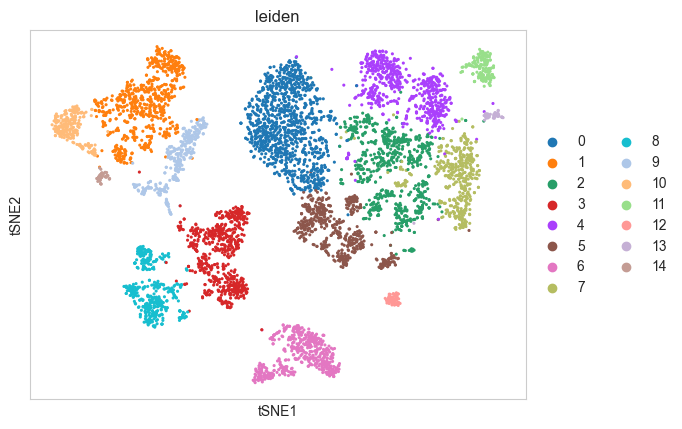

In [13]:
rna_hv = add_cluster_info(rna, resolution=0.5, cluster_by='highly_variable')

In [14]:
match_list_df, protein_df, train_dataset, test_dataset = make_infer_dataset(rna_hv, screen_num, scMS, valid_ratio=0.3)

/media/yuzhi/Data/scInfer_for_submit/scInfer/scInferCode/utils.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ids.groupby(by)


In [22]:
input_size = train_dataset.get_size() 
batch_size = 2048
num_epochs = 40
lr = 0.5
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferNetwork(input_size,output_size=screen_num, t=temperature).to(device)
criterion = ClusterLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [23]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=False)

In [24]:
model = train_infer(train_loader, test_loader, model, criterion, num_epochs, patience, optimizer, batch_size, device)

Training:  85%|████████▌ | 34/40 [01:02<00:11,  1.85s/epoch, train_loss=0.0031464748, test_loss=0.0424794627, lr=0.328050]

Early stopping at epoch 34. Best Test Loss: 0.041409


In [25]:
model_path = f'./scInferData/BreastTask/Unpaired_Benchmark_Breast_Infer.pth'

### 注意是否保存了模型参数

In [26]:
# torch.save(model.state_dict(), model_path)

In [27]:
model = InferNetwork(input_size,output_size=screen_num, t=temperature).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [28]:
model.eval()

InferNetwork(
  (features): Sequential(
    (0): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1408, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [29]:
rna_res = infer_protein(protein_df, match_list_df, device, model, scMS, rna, screen_num)

In [30]:
rna_res.write('./scInferData/BreastTask/benchmark_final_inference.h5ad')